In [1]:
%matplotlib inline
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps, ImageFilter
from scipy.ndimage.filters import laplace, generic_filter
from scipy.ndimage import (gaussian_gradient_magnitude, sobel,
                           maximum_filter, gaussian_laplace)

from dataset_utils import load_grayscale, img_to_dataset, grid_plot

from tensorflow import keras as K
import tensorflow as tf

In [2]:
tf.__version__

'2.1.0'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## loading the data

In [4]:
data_source = '/net/people/plgmatisz/antibodies/data/original/'
glob.glob(data_source + '*')

['/net/people/plgmatisz/antibodies/data/original/negatives',
 '/net/people/plgmatisz/antibodies/data/original/AMA',
 '/net/people/plgmatisz/antibodies/data/original/nucleolar',
 '/net/people/plgmatisz/antibodies/data/original/ziarnisty+homogenny',
 '/net/people/plgmatisz/antibodies/data/original/ACA',
 '/net/people/plgmatisz/antibodies/data/original/ziarnisty',
 '/net/people/plgmatisz/antibodies/data/original/fibrilar',
 '/net/people/plgmatisz/antibodies/data/original/ziarnisty+nucleolar',
 '/net/people/plgmatisz/antibodies/data/original/homogenous',
 '/net/people/plgmatisz/antibodies/data/original/ziarnisty+cytoplazmatyczny',
 '/net/people/plgmatisz/antibodies/data/original/nuclear_dots']

In [5]:
classes_to_load = {
    'ZIA': 'ziarnisty',
    'HOM': 'homogenous'
}

files_limit = 100

files_dict = {key: glob.glob(f'{data_source}/{dir_}/*')[:files_limit] for key, dir_ in classes_to_load.items()}

for k, v in files_dict.items():
    print(f'{k}: {len(v)}')

ZIA: 100
HOM: 70


CPU times: user 1.57 s, sys: 347 ms, total: 1.92 s
Wall time: 1.99 s


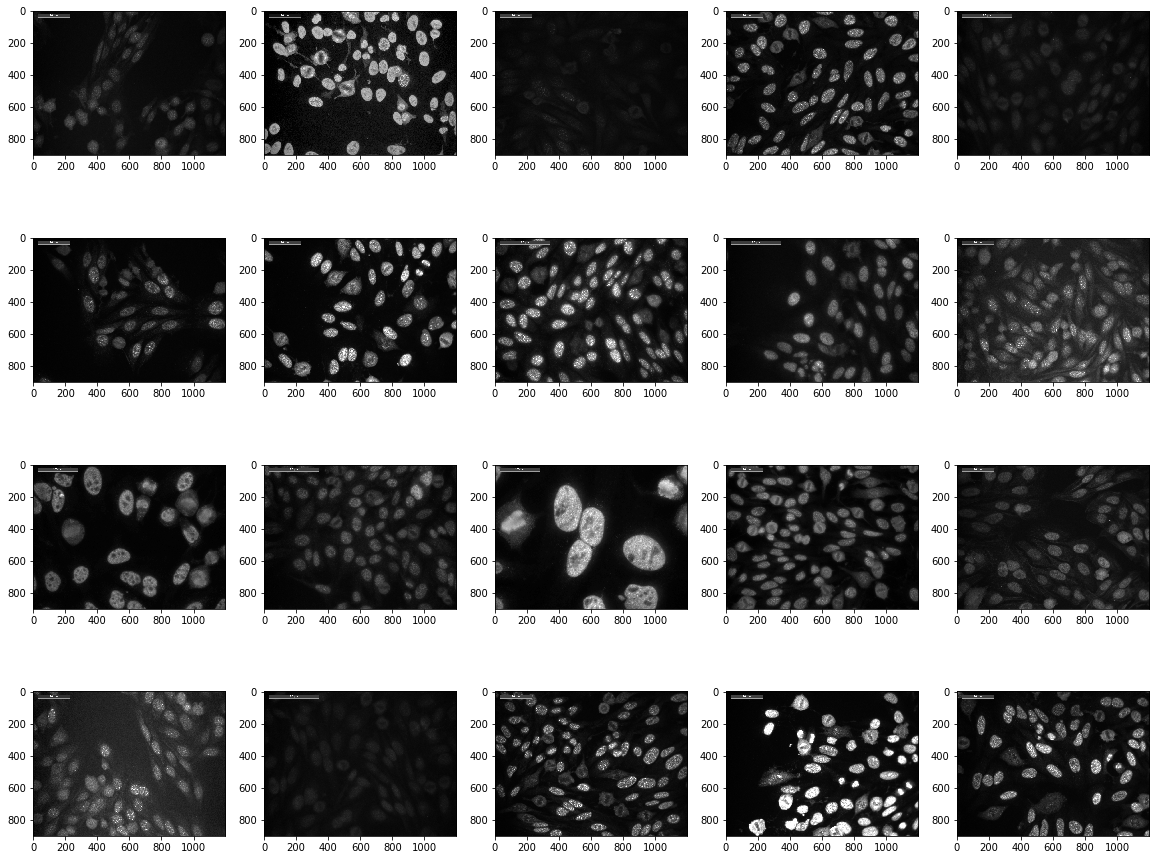

In [8]:
%%time

img_size = (1200, 900)

imgs_dict = {key: np.array([load_grayscale(f, img_size) for f in files]) for key, files in files_dict.items()}

plt.figure(figsize=(20, 16))
grid_plot(imgs_dict['ZIA'], 4, 5, method='imshow', cmap='gray')

## defining datasets

In [11]:
%%time

params = {
    
    # params for detecting ROI
    'roi_window_size': 20,
    'roi_stride': 5,
    'roi_threshold': 3.,
    
    # params for extracting dataset windows
    'img_window_size': 128,
    'img_window_stride': 24,
    'img_neg_threshold': 0.05,
    'img_pos_threshold': 0.7
}

hom_imgs = imgs_dict['HOM']
zia_imgs = imgs_dict['ZIA']


train_imgs_count = 20
test_imgs_count = 8

hom_train_datasets = [img_to_dataset(img, params) for img in hom_imgs[:train_imgs_count]]
hom_test_datasets = [img_to_dataset(img, params) for img in hom_imgs[-test_imgs_count:]]

zia_train_datasets = [img_to_dataset(img, params) for img in zia_imgs[:train_imgs_count]]
zia_test_datasets = [img_to_dataset(img, params) for img in zia_imgs[-test_imgs_count:]]

hom_train = np.concatenate([ds[1] for ds in hom_train_datasets])
hom_test = np.concatenate([ds[1] for ds in hom_test_datasets])

zia_train = np.concatenate([ds[1] for ds in zia_train_datasets])
zia_test = np.concatenate([ds[1] for ds in zia_test_datasets])

print(f'hom: train - {hom_train.shape}, test - {hom_test.shape}')
print(f'zia: train - {zia_train.shape}, test - {zia_test.shape}')

hom: train - (7112, 128, 128), test - (4261, 128, 128)
zia: train - (8071, 128, 128), test - (3504, 128, 128)
CPU times: user 14.6 s, sys: 10.6 s, total: 25.2 s
Wall time: 25.2 s


[1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0.]


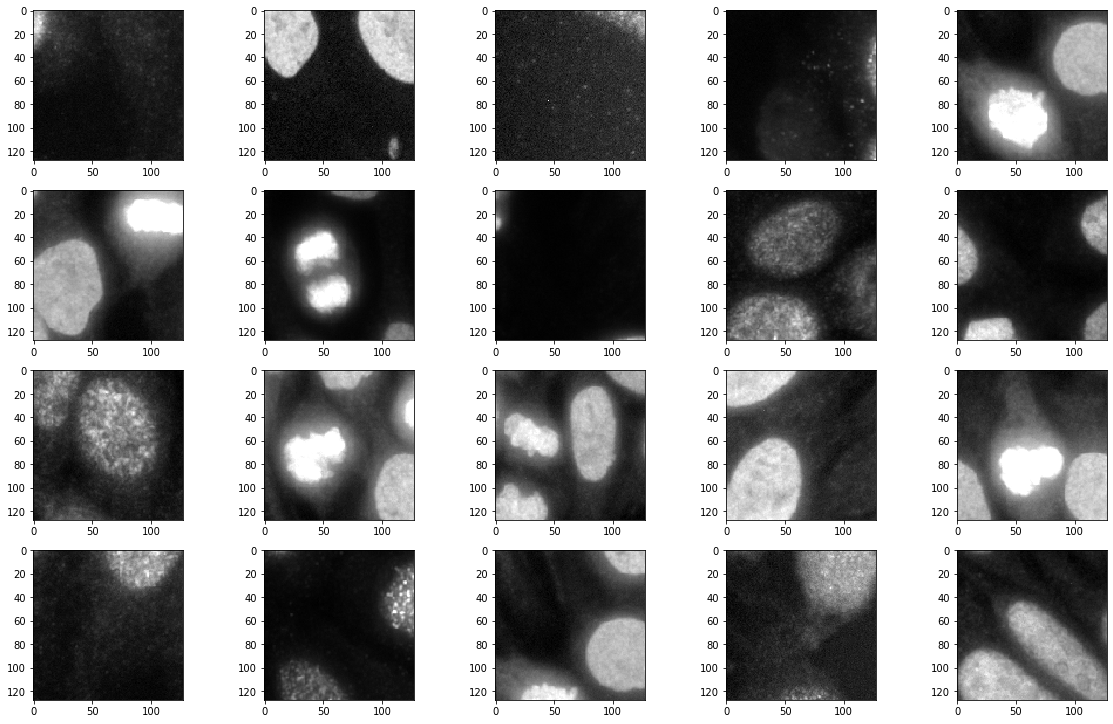

In [12]:
train_samples_per_class = 7_000
test_samples_per_class = 2_000

X_train = np.concatenate([hom_train[:train_samples_per_class], zia_train[:train_samples_per_class]])
X_test = np.concatenate([hom_test[:test_samples_per_class], zia_test[:test_samples_per_class]])

y_train = np.concatenate([
    np.zeros(train_samples_per_class),
    np.ones(train_samples_per_class)
])

y_test = np.concatenate([
    np.zeros(test_samples_per_class),
    np.ones(test_samples_per_class)
])

train_indeces = np.array(range(X_train.shape[0]))
rand_train_indeces = np.random.choice(train_indeces, 20)

plt.figure(figsize=(20, 16))
grid_plot(X_train[rand_train_indeces], cmap='gray')

print(y_train[rand_train_indeces])

## network training

In [13]:
model_input = K.layers.Input(shape=(128, 128, 1), name='img')
x = K.layers.Conv2D(8, 11, activation='relu')(model_input)
x = K.layers.Conv2D(8, 11, activation='relu')(x)
x = K.layers.MaxPooling2D(2)(x)
x = K.layers.Conv2D(8, 7, activation='relu')(x)
x = K.layers.Conv2D(8, 7, activation='relu')(x)
x = K.layers.MaxPooling2D(2)(x)
x = K.layers.Conv2D(8, 5, activation='relu')(x)
x = K.layers.Conv2D(8, 5, activation='relu')(x)
x = K.layers.MaxPooling2D(2)(x)
x = K.layers.Flatten()(x)
x = K.layers.Dense(10, activation='relu')(x)
model_output = K.layers.Dense(1, activation='sigmoid')(x)

model = K.Model(model_input, model_output, name='cells-classifier')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "cells-classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 118, 118, 8)       976       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 8)       7752      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 54, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 8)         3144      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 8)         3144      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 8)    

In [14]:
history = model.fit(
    np.expand_dims(X_train, axis=3), y_train,
    epochs=30,
    batch_size=256,
    validation_data=(np.expand_dims(X_test, axis=3), y_test)
)

Train on 14000 samples, validate on 4000 samples
Epoch 1/30
14000/14000 [==============================] - 14s 998us/sample - loss: 0.7045 - acc: 0.5087 - val_loss: 0.6909 - val_acc: 0.5477
Epoch 2/30
14000/14000 [==============================] - 5s 360us/sample - loss: 0.6919 - acc: 0.5583 - val_loss: 0.6946 - val_acc: 0.4902
Epoch 3/30
14000/14000 [==============================] - 5s 368us/sample - loss: 0.6818 - acc: 0.5671 - val_loss: 0.5828 - val_acc: 0.5415
Epoch 4/30
14000/14000 [==============================] - 5s 367us/sample - loss: 0.6105 - acc: 0.6895 - val_loss: 0.5247 - val_acc: 0.7025
Epoch 5/30
14000/14000 [==============================] - 5s 360us/sample - loss: 0.5380 - acc: 0.7522 - val_loss: 0.3756 - val_acc: 0.8700
Epoch 6/30
14000/14000 [==============================] - 5s 363us/sample - loss: 0.4969 - acc: 0.7707 - val_loss: 0.3503 - val_acc: 0.8813
Epoch 7/30
14000/14000 [==============================] - 5s 361us/sample - loss: 0.4429 - acc: 0.8115 - val_l

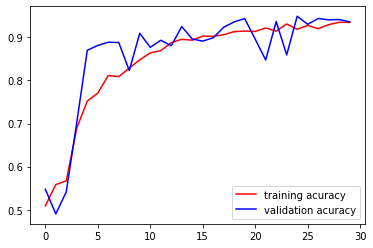

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(acc, c='red', label='training acuracy')
plt.plot(val_acc, c='blue', label='validation acuracy')
plt.legend()

In [16]:
pred_test = model.predict(np.expand_dims(X_test, axis=3)).reshape(-1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0.88 1.   0.99 0.64 0.71 0.81 0.85 0.92 0.97 0.57 0.91 0.96 0.89 0.56
 0.61 0.92 0.92 0.95 0.83 0.56 0.71 0.61 0.83 0.88 0.77 0.59 0.72 0.73
 0.5  1.   1.   1.   1.   0.58 0.7  0.77 0.51 0.85 0.91 0.91 0.99 0.83
 0.76 0.89 0.7  0.71 0.58 0.51 0.6  1.  ]


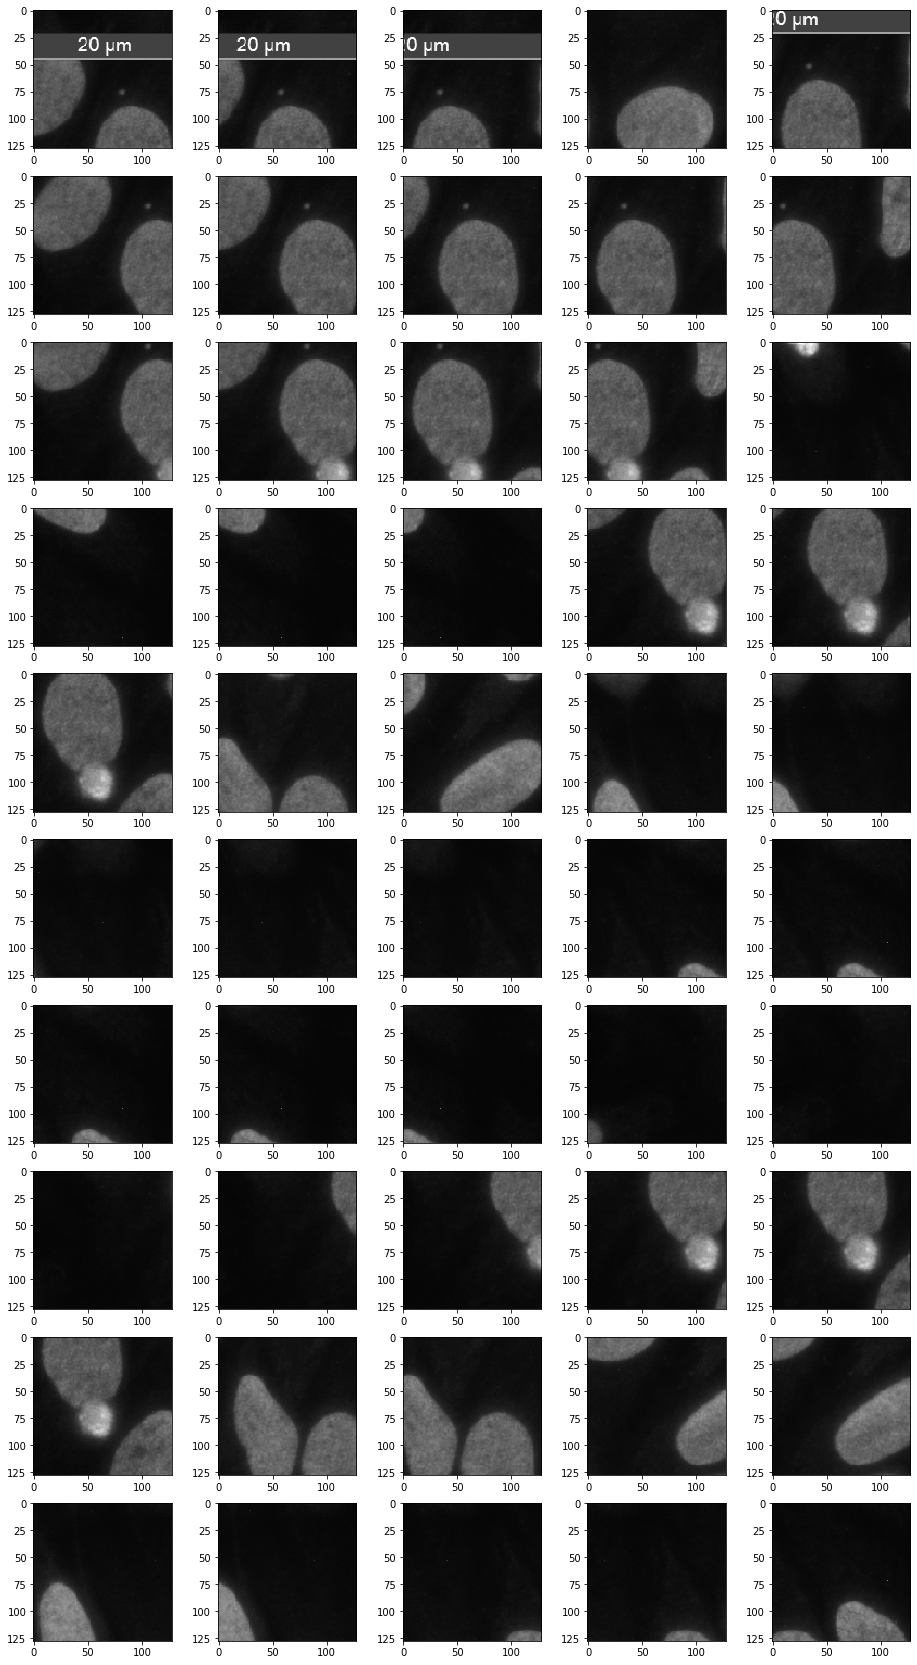

In [17]:
incorrect = (pred_test > 0.5) != y_test


plt.figure(figsize=(16, 30))
grid_plot(X_test[incorrect], 10, 5, vmin=0, vmax=255, cmap='gray')

print(y_test[incorrect][:50])
print(np.round(pred_test[incorrect][:50], decimals=2))